In [2]:
import pandas as pd
import math
import csv

hh_df = pd.read_csv('../../Data/SMTO_2015/SMTO_2015_Households.csv')
ps_df = pd.read_csv('../../Data/SMTO_2015/SMTO_2015_Respondents.csv')
campus_info = pd.read_csv('../../Data/SMTO_2015/Campus_Info.csv')

# Load relevant columns
df = ps_df[['pscampusattend', 'personstatusgrad', 'personstatustime','psmainmodefalltypical', 'pscmpgender', 'psdrivinglicenseownerflag', 'psworknumhoursperweek', 'psborrowcar', 'pstraveltimetypfallcommute']]
df = df.join(hh_df[['HmTTS2006', 'hhlivingsituation', 'hhcarnumber','hhnumyoungerthan18','hhnumolderorequalto18','hhincomelevel']])

df = df.rename(columns={'HmTTS2006': 'HomeZone', 'pscampusattend': 'Campus', 'hhlivingsituation': 'Family', 'psmainmodefalltypical': 'Mode', 
                       'personstatusgrad': 'Level', 'personstatustime': 'Status', 'psuniversityinvolvednumyears': 'Years', 'hhcarnumber': 'Cars',
                       'hhincomelevel': 'Income', 'pscmpgender': 'Gender', 'psdrivinglicenseownerflag': 'Licence', 'psworknumhoursperweek': 'Work',
                       'hhnumyoungerthan18': 'Children', 'hhnumolderorequalto18':'Adults', 'psborrowcar': 'Car_Avail', 'pstraveltimetypfallcommute': 'Time'})

mode_name_to_num = {"Car - Driver alone": "Auto", "Car - Driver with passenger(s)": "Auto", "Car - Passenger": "Auto", "Taxi": "Auto", 
                    "Transit Bus": "Transit", "Streetcar": "Transit", "Subway/RT": "Transit", "GO Bus": "Transit", "GO Train": "Transit", 
                    "Walk": "Walk", "Bicycle": "Bicycle"}
print(df.shape)

df.replace({'Mode': mode_name_to_num}, inplace=True)
df = df[(df['Mode'] == "Auto") | (df['Mode'] == "Transit") | (df['Mode'] == "Walk") | (df['Mode'] == 'Bicycle')]
print(df.shape)

df['Work'].fillna('Unknown', inplace=True) # Fill 11,000 Work NaNs with "Unknowns"
df['Car_Avail'].fillna(0, inplace = True)
df = df.dropna() # Remove rows with missing data
print(df.shape)


# Convert Campus column to numerical column
df['Campus'] = df["Campus"].apply(lambda x: campus_info.Zone[campus_info['School'] == x].tolist()[0])
print(df.shape)

# Convert columns to numerical
df['HomeZone'] = pd.to_numeric(df['HomeZone'], downcast='signed')
df['Car_Avail'] = pd.to_numeric(df['Car_Avail'], downcast='signed')

print(df.shape)
df.head()


(15226, 15)
(15066, 15)
(14839, 15)
(14839, 15)
(14839, 15)


,Campus,Level,Status,Mode,Gender,Licence,Work,Car_Avail,Time,HomeZone,Family,Cars,Children,Adults,Income
0,566,UG,FT,Transit,Female,0,Unknown,0,42.84,261,Live with family/parents,1,3,4,Unknown
1,69,Grad,FT,Walk,Female,1,Unknown,0,3.41,71,Live with partner,0,0,2,"$ 90,000 - 119,999"
2,69,UG,FT,Transit,Female,1,Unknown,1,69.76,3714,Live with family/parents,1,0,4,Unknown
3,69,UG,FT,Walk,Male,1,Unknown,1,17.22,74,Live with roommates,0,0,4,Unknown
4,69,Grad,FT,Walk,Male,1,Unknown,0,6.59,71,Live with partner,0,0,2,"$ 30,000 - 59,999"


In [2]:
def row_to_segment(x):
    if x.Level == 'Other':
        return 0
    elif x.Level == 'UG':
        return 3 if x.Status == 'PT' else (not x.Family) + 1
    else:
        return 6 if x.Status == 'PT' else (4 + (not x.Family))

df['Segment'] = df.apply(row_to_segment, axis=1)

In [5]:
# Dataframe with walk distances
df_path = pd.read_csv('../../../LoS/Walk_Distances.csv')
origins = list(set(list(df_path['Origin'])))
dists = list(df_path['Data'])

# Dataframe with AutoTravelTimes
df_att = pd.read_csv('../../../LoS/Auto_Travel_Times.csv')
AutoTravelTimes = list(df_att['Data'])

# Dataframe with TransitTravelTimes
df_ttt = pd.read_csv('../../../LoS/Transit_Travel_Times.csv')
TransitTravelTimes = list(df_ttt['Data'])

not_found = set()

# Function for distance/AutoTravelTime/TransitTravelTime lookup
def find_value(origin, destination, mode_num):
    # mode_num: 0 - to find Auto Travel Time
    #           1 - to find Transit Travel Time
    #           2 - to find Walking Travel Time
    #           5 - to find Biking Travel Time
    try:
        i = origins.index(origin)
    except ValueError:
        not_found.add(origin)
        return -1
    try:
        j = origins.index(destination)
    except ValueError:
        not_found.add(destination)
        return -1
    
    if mode_num == 0:
        return AutoTravelTimes[i*2392 + j]
    elif mode_num == 1:
        return TransitTravelTimes[i*2392 + j]
    elif mode_num == 2:
        return dists[i*2392 + j] * 15/1000 # This was changed from walking distance to walking time
    elif mode_num == 5:
        return dists[i*2392 + j] * 4/1000 # Distance to biking time
    else:
        print("ERROR: Enter correct mode_num!")
        return 0

'''
# List of campus' TTS zones from Joven's MOE data
campus_zones = list(campus_info['Zone'])
school_codes = list(campus_info['Code'])

# Load distances into dataframe
for i in range(len(campus_zones)):
    df["Dist." + school_codes[i]] = df['HomeZone'].apply(lambda x: find_distance(x, campus_zones[i]))
print("# of zones not found:", len(not_found))
'''

# Add columns for Distance, Transit Travel Time, Auto Travel Time, Auto Cost, Transit Cost
df['Time.Auto'] = df.apply(lambda x: find_value(x.HomeZone, x.Campus, 0), axis=1)
df['Time.Transit'] = df.apply(lambda x: find_value(x.HomeZone, x.Campus, 1), axis=1)
df['Time.Walk'] = df.apply(lambda x: find_value(x.HomeZone, x.Campus, 2), axis=1)
df['Time.Bicycle'] = df['Time.Walk'] * 4 / 15
#df['Cost.Auto'] = df.apply(lambda x: find_value(x.HomeZone, x.CampusZone, 3), axis=1)
#df['Cost.Transit'] = df.apply(lambda x: find_value(x.HomeZone, x.CampusZone, 4), axis=1)

df.head()

,Campus,Level,Status,Mode,Gender,Licence,Work,Car_Avail,Time,HomeZone,Family,Cars,Children,Adults,Income,Time.Auto,Time.Transit,Time.Walk,Time.Bicycle
0,566,UG,FT,Transit,Female,0,Unknown,0,42.84,261,Live with family/parents,1,3,4,Unknown,17.474220,75.468478,223.214700,59.523920
1,69,Grad,FT,Walk,Female,1,Unknown,0,3.41,71,Live with partner,0,0,2,"$ 90,000 - 119,999",2.924953,24.128386,16.985265,4.529404
2,69,UG,FT,Transit,Female,1,Unknown,1,69.76,3714,Live with family/parents,1,0,4,Unknown,50.171880,155.551170,349.788450,93.276920
3,69,UG,FT,Walk,Male,1,Unknown,1,17.22,74,Live with roommates,0,0,4,Unknown,1.049121,16.675728,10.491210,2.797656
4,69,Grad,FT,Walk,Male,1,Unknown,0,6.59,71,Live with partner,0,0,2,"$ 30,000 - 59,999",2.924953,24.128386,16.985265,4.529404


In [12]:
df = df[df['Time.Walk'] != -1]
df.head()

,Campus,Level,Status,Mode,Gender,Licence,Work,Car_Avail,Time,HomeZone,Family,Cars,Children,Adults,Income,Time.Auto,Time.Transit,Time.Walk,Time.Bicycle
0,566,UG,FT,Transit,Female,0,Unknown,0,42.84,261,Live with family/parents,1,3,4,Unknown,17.474220,75.468478,223.214700,59.523920
1,69,Grad,FT,Walk,Female,1,Unknown,0,3.41,71,Live with partner,0,0,2,"$ 90,000 - 119,999",2.924953,24.128386,16.985265,4.529404
2,69,UG,FT,Transit,Female,1,Unknown,1,69.76,3714,Live with family/parents,1,0,4,Unknown,50.171880,155.551170,349.788450,93.276920
3,69,UG,FT,Walk,Male,1,Unknown,1,17.22,74,Live with roommates,0,0,4,Unknown,1.049121,16.675728,10.491210,2.797656
4,69,Grad,FT,Walk,Male,1,Unknown,0,6.59,71,Live with partner,0,0,2,"$ 30,000 - 59,999",2.924953,24.128386,16.985265,4.529404


In [15]:
walk_df = df[df['Mode'] == 'Walk']
bike_df = df[df['Mode'] == 'Bicycle']
walk_df[['Time', 'Time.Walk']].describe()

,Time,Time.Walk
count,2851.000000,2851.000000
mean,16.108011,27.514349
std,9.790392,57.913393
min,0.000000,0.000000
25%,10.380000,11.563035
50%,15.700000,19.466160
75%,21.010000,26.595510
max,70.000000,992.399250


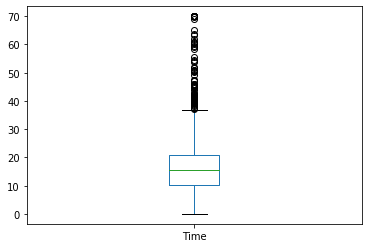

In [17]:
walk_df['Time'].plot.box()

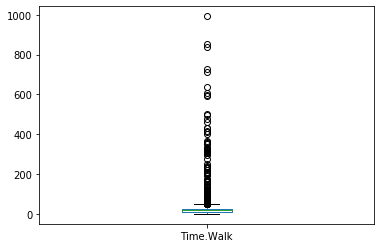

In [18]:
walk_df['Time.Walk'].plot.box()

In [51]:
print((abs(walk_df['Time.Walk'] - walk_df['Time']) < 15).sum()/2851)
(walk_df['Time.Walk'] - walk_df['Time']).describe()

0.8372500876885304


count    2851.000000
mean       11.406338
std        56.506313
min       -70.000000
25%        -2.210000
50%         3.138600
75%         9.657142
max       983.379250
dtype: float64

In [25]:
bike_df[['Time', 'Time.Bicycle']].describe()

,Time,Time.Bicycle
count,1032.000000,1032.000000
mean,19.471017,16.025199
std,10.970953,16.923810
min,0.000000,0.000000
25%,11.587500,6.380704
50%,17.030000,11.983040
75%,24.982500,19.086392
max,70.000000,188.451680


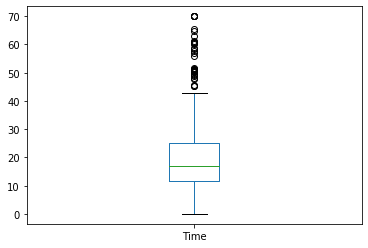

In [27]:
bike_df['Time'].plot.box()

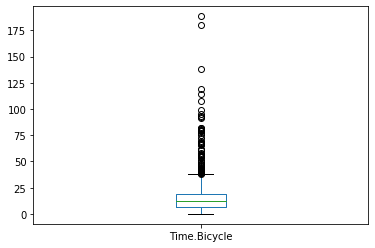

In [30]:
bike_df['Time.Bicycle'].plot.box()

In [50]:
print((abs(bike_df['Time.Bicycle'] - bike_df['Time']) < 15).sum() / 1032)
(bike_df['Time.Bicycle'] - bike_df['Time']).describe()

0.9089147286821705


count    1032.000000
mean       -3.445818
std        13.578371
min       -38.906960
25%        -8.038380
50%        -4.710944
75%        -1.679826
max       178.901680
dtype: float64

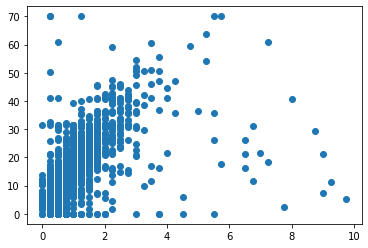

In [41]:
import matplotlib.pyplot as plt
walk = ps_df[ps_df['psmainmodefalltypical'] == 'Walk']
walk = walk[walk['HomeToMainCampusKM'] < 10]
plt.scatter(walk['HomeToMainCampusKM'], walk['pstraveltimetypfallcommute'])